Optimizer
=========

Optimizer Process
------------

1. 준비단계
- 세팅 설정
- 시각화 함수 정의하기

2. 데이터 수집
- 주요 파라미터 지정해주기
- 데이터 수집하기
- 데이터 형태 맞춰주기

3. 모델 생성
- 모델 생성해주기
- 모델 학습을 위한 최적화 방법, loss 계산법, 평가지표 지정하기
- 모델 상태 출력해보기

4. 모델 학습

5. 시각화로 최종 결과 확인

영화 사이트 IMDB의 리뷰 데이터 감성 분류하기 : SGD
---------------

SGD parameters
------

lr : learning rate (lr >= 0)
1, 0.1, 0.009, 0.01, 0.03, 0.001, 0.0001 -> 꺾이면 learning rate 낮춰주기, 한 번 휘면 다시 안돌아옴, 잘 조정하자

momentum : 진동을 막아주고 SGD를 가속화하는 파라메터(momentum >= 0) -> 높을수록 휜다
0.5, 0.9, 0.95, 0.99

nesterov : 미분 지점을 유연하게 변경하도록 돕는 파라메터(nesterov = True / False)

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers
import warnings

warnings.filterwarnings('ignore')

In [54]:
# 리뷰 데이터 shape 맞춰주기
def sequence_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        # 리뷰 별 빈도수가 높은 단어를 dimension 개수만큼 추출하여 사용함
        results[i, word_indices] = 1.0 
        
    return results

In [55]:
# 시각화 하기
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.savefig("pictures/sgd_plot.png")

In [56]:
# 많이 사용하는 단어 추출할 수 정하기
word_num = 100
data_num = 25000

In [57]:
# 데이터 불러오기
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

In [58]:
# 데이터 살펴보기
# train data에서 각 숫자는 단어의 발생빈도 순위를 의미함
# 14 : 전체 단어 중 발생 빈도 14등
print(train_data[0])
print('The shape of train data :', train_data.shape, '\n')
print(train_labels[0])
print('The shape of test data :', test_data.shape)

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 2, 36, 2, 5, 25, 2, 43, 2, 2, 50, 2, 2, 9, 35, 2, 2, 5, 2, 4, 2, 2, 2, 2, 2, 2, 39, 4, 2, 2, 2, 17, 2, 38, 13, 2, 4, 2, 50, 16, 6, 2, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 2, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 2, 12, 16, 38, 2, 5, 25, 2, 51, 36, 2, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 2, 2, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 2, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 2, 6, 2, 2, 18, 4, 2, 22, 21, 2, 2, 26, 2, 5, 2, 30, 2, 18, 51, 36, 28, 2, 92, 25, 2, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 2, 2, 32, 15, 16, 2, 19, 2, 32]
The shape of train data : (25000,) 

1
The shape of test data : (25000,)


In [59]:
# 감성 정보에서 긍정을 의미하는 1, 부정을 의미하는 0
np.unique(train_labels)

array([0, 1], dtype=int64)

In [60]:
# 데이터 shape 맞춰주기
# 단어 빈도수 100등 이내의 단어만 사용하여 쓰겠음
train_data = sequence_shaping(train_data, dimension=word_num)
test_data = sequence_shaping(test_data, dimension=word_num)

In [61]:
# Optimizer 모델과 비교를 위한 base 모델 생성해주기
# 100개 단어의 input을 받아 활성화 함수를 거쳐 128개의 데이터를 생성해주고
# 다시 relu 활성화함수를 거쳐 128개의 데이터를 생성하고
# 시그모이드 함수를 거쳐 긍정, 부정이라는 단 하나의 결과값을 출력함
basic_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)), 
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [62]:
# Optimizer model 생성해주기
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)), 
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [63]:
# base 모델을 학습시킬 최적화 방법, loss 계산법, 평가 방법 설정
basic_model.compile(optimizer='sgd',
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', 'binary_crossentropy'])

In [64]:
# base 현재 모델 상태 출력
basic_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________


In [65]:
# base 모델 학습
basic_history = basic_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels), verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.7062 - accuracy: 0.5034 - binary_crossentropy: 0.7062 - val_loss: 0.6929 - val_accuracy: 0.5219 - val_binary_crossentropy: 0.6929
Epoch 2/20
25000/25000 - 0s - loss: 0.6893 - accuracy: 0.5355 - binary_crossentropy: 0.6893 - val_loss: 0.6855 - val_accuracy: 0.5548 - val_binary_crossentropy: 0.6855
Epoch 3/20
25000/25000 - 0s - loss: 0.6820 - accuracy: 0.5658 - binary_crossentropy: 0.6820 - val_loss: 0.6787 - val_accuracy: 0.5778 - val_binary_crossentropy: 0.6787
Epoch 4/20
25000/25000 - 0s - loss: 0.6752 - accuracy: 0.5890 - binary_crossentropy: 0.6752 - val_loss: 0.6722 - val_accuracy: 0.5985 - val_binary_crossentropy: 0.6722
Epoch 5/20
25000/25000 - 0s - loss: 0.6685 - accuracy: 0.6072 - binary_crossentropy: 0.6685 - val_loss: 0.6659 - val_accuracy: 0.6148 - val_binary_crossentropy: 0.6659
Epoch 6/20
25000/25000 - 0s - loss: 0.6620 - accuracy: 0.6211 - binary_crossentropy: 0.6620 - val_loss: 0.6596

In [66]:
# optimized 모델을 학습시킬 최적화 방법, loss 계산법, 평가 방법 설정
optimizer_model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy', 'binary_crossentropy'])

In [67]:
# optimized 모델의 상태 출력
optimizer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________


In [68]:
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 0s - loss: 0.6812 - accuracy: 0.5632 - binary_crossentropy: 0.6812 - val_loss: 0.6604 - val_accuracy: 0.6211 - val_binary_crossentropy: 0.6604
Epoch 2/20
25000/25000 - 0s - loss: 0.6382 - accuracy: 0.6460 - binary_crossentropy: 0.6382 - val_loss: 0.6191 - val_accuracy: 0.6648 - val_binary_crossentropy: 0.6191
Epoch 3/20
25000/25000 - 0s - loss: 0.5998 - accuracy: 0.6806 - binary_crossentropy: 0.5998 - val_loss: 0.5886 - val_accuracy: 0.6883 - val_binary_crossentropy: 0.5886
Epoch 4/20
25000/25000 - 0s - loss: 0.5775 - accuracy: 0.6971 - binary_crossentropy: 0.5775 - val_loss: 0.5754 - val_accuracy: 0.7012 - val_binary_crossentropy: 0.5754
Epoch 5/20
25000/25000 - 0s - loss: 0.5695 - accuracy: 0.7037 - binary_crossentropy: 0.5695 - val_loss: 0.5700 - val_accuracy: 0.7038 - val_binary_crossentropy: 0.5700
Epoch 6/20
25000/25000 - 0s - loss: 0.5657 - accuracy: 0.7060 - binary_crossentropy: 0.5657 - val_loss: 0.5685

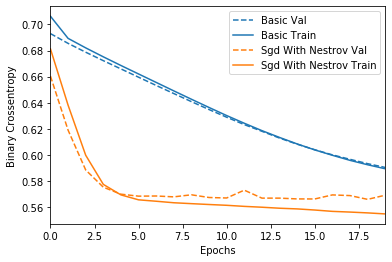

In [69]:
# 각 모델별 loss 그래프 시각화
Visulaize([('Basic', basic_history), ('SGD with nestrov', optimizer_history)])

In [70]:
# history 정보 살펴보기
print(optimizer_history.epoch)
print(optimizer_history.history)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
{'loss': [0.6812285459041596, 0.6381710124015808, 0.5998462116718293, 0.5775277626514435, 0.5694829761981964, 0.565702565908432, 0.5646229338645935, 0.5634682261943817, 0.5627804458141327, 0.5621239387989044, 0.5615171074867249, 0.5606922972202301, 0.5600455391407013, 0.5592790162563324, 0.5587595176696777, 0.557901782989502, 0.5568704783916474, 0.556337958574295, 0.555703649520874, 0.5549224483966827], 'accuracy': [0.56324, 0.64604, 0.68064, 0.69712, 0.70372, 0.70604, 0.70724, 0.70792, 0.70964, 0.70968, 0.71072, 0.71116, 0.71048, 0.71236, 0.71288, 0.71268, 0.71316, 0.71236, 0.71448, 0.71448], 'binary_crossentropy': [0.6812285, 0.638171, 0.5998462, 0.57752776, 0.569483, 0.5657026, 0.564623, 0.5634682, 0.56278044, 0.562124, 0.5615172, 0.5606923, 0.5600455, 0.55927896, 0.5587595, 0.55790174, 0.5568705, 0.55633795, 0.55570364, 0.5549224], 'val_loss': [0.6604106807708741, 0.6190580713748932, 0.5885597157478333, 0.575370

Adagrad optimizer
--------------

lr : learning rate (lr >= 0)  
epsilon : 연산 시 분모가 0이 되는 것을 막는 0에 가까운 상수(epsilon >= 0; None = default K.epsilon())  
decay : 각 업데이트 시 learning rate를 비율 만큼 줄여 주는 파라메터(decay >= 0)  
  
learning rate만 조정해주는 것이 바람직하다

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 0s - loss: 0.6955 - accuracy: 0.5264 - binary_crossentropy: 0.6955 - val_loss: 0.6888 - val_accuracy: 0.5373 - val_binary_crossentropy: 0.6888
Epoch 2/20
25000/25000 - 0s - loss: 0.6843 - accuracy: 0.5574 - binary_crossentropy: 0.6843 - val_loss: 0.6811 - val_accuracy: 0.5700 - val_binary_crossentropy: 0

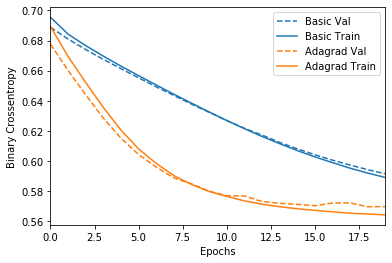

In [77]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

def sequences_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  
        
    return results


def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.savefig("plot.png")


word_num = 100
data_num = 25000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)


train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)


basic_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
basic_model.summary()
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)


optimizer_model.compile(optimizer=optimizers.Adagrad(lr=0.01, epsilon=None, decay = 0.0),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
optimizer_model.summary()
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


Visulaize([('Basic', basic_history),('Adagrad', optimizer_history)])

Adadelta Optimizer
-----------

lr : 초기 learning rate (lr >= 0)  
rho : Adadelta decay factor (rho >= 0)  
epsilon : 연산 시 분모가 0이 되는 것을 막는 0에 가까운 상수(epsilon >= 0; None = default K.epsilon())  
decay : 각 업데이트 시 learning rate를 비율 만큼 줄여 주는 파라메터(decay >= 0)  -> step size 감소시켜줌

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 0s - loss: 0.6977 - accuracy: 0.4961 - binary_crossentropy: 0.6977 - val_loss: 0.6928 - val_accuracy: 0.5178 - val_binary_crossentropy: 0.6928
Epoch 2/20
25000/25000 - 0s - loss: 0.6906 - accuracy: 0.5245 - binary_crossentropy: 0.6906 - val_loss: 0.6865 - val_accuracy: 0.5448 - val_binary_crossentropy: 

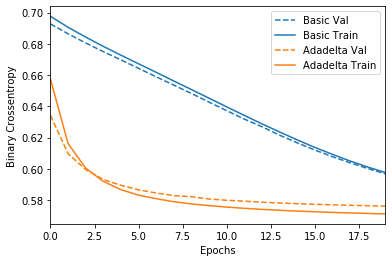

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers


def sequences_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  
    return results


def Visulaize(histories, key='binary_crossentropy'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.savefig("plot.png")
    plt.show()

word_num = 100
data_num = 25000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

basic_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
basic_model.summary()
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.1),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
optimizer_model.summary()
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)

Visulaize([('Basic', basic_history),('Adadelta', optimizer_history)])

RMSProp Optimizer
----------

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6951 - accuracy: 0.5194 - binary_crossentropy: 0.6951 - val_loss: 0.6903 - val_accuracy: 0.5286 - val_binary_crossentropy: 0.6903
Epoch 2/20
25000/25000 - 0s - loss: 0.6867 - accuracy: 0.5461 - binary_crossentropy: 0.6867 - val_loss: 0.6841 - val_accuracy: 0.5505 - val_binary_crossentropy: 

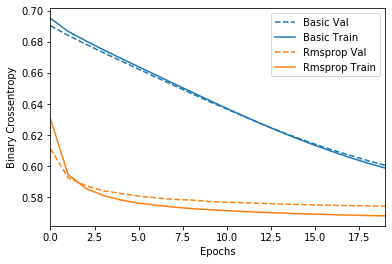

In [84]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

def sequences_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  
    return results


def Visulaize(histories, key='binary_crossentropy'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.savefig("plot.png")
    plt.show()

word_num = 100
data_num = 25000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)


basic_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])

basic_model.summary()
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)


optimizer_model.compile(optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.1),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
optimizer_model.summary()
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)

Visulaize([('Basic', basic_history),('RMSprop', optimizer_history)])

Adam Optimizer
-------

lr : learning rate ( lr >= 0 )  
beta_1 : momentum을 결정하기 위해 사용되는 파라메터(beta_1 >= 0 )  
beta_2 : step size를 결정하기 위해 사용되는 파라메터(beta_2 >= 0)  

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6975 - accuracy: 0.5204 - binary_crossentropy: 0.6975 - val_loss: 0.6880 - val_accuracy: 0.5400 - val_binary_crossentropy: 0.6880
Epoch 2/20
25000/25000 - 0s - loss: 0.6845 - accuracy: 0.5517 - binary_crossentropy: 0.6845 - val_loss: 0.6813 - val_accuracy: 0.5638 - val_binary_crossentropy: 

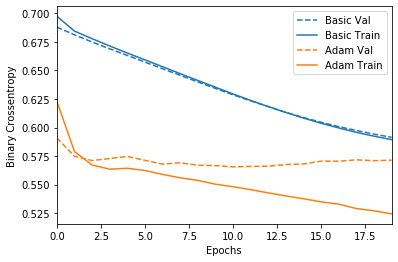

In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

def sequences_shaping(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  
    return results

def Visulaize(histories, key='binary_crossentropy'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

    plt.savefig("plot.png")
    plt.show()

word_num = 100
data_num = 25000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

basic_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
basic_model.summary()
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.Adam(lr=0.0008, beta_1=0.99999, beta_2=0.99999),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
optimizer_model.summary()
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


Visulaize([('Basic', basic_history),('Adam', optimizer_history)])